# Class 3B - Data Wrangling with Pandas II

We will begin at 12:05 PM! Until then, feel free to use the chat to socialize, and enjoy the music!

<img src="images/pipelines.jpg" width=50% style="margin-left:auto; margin-right:auto">


<div align = "left"> 
    <br>
    <br>
Image by <a href="https://pixabay.com/photos/lost-places-factory-old-abandoned-2178884/">Hands off my tags! Michael Gaida</a> from Pixabay.
</div>

<div align = "right"> 
    July 21, 2021 <br>
    Firas Moosvi
</div>

## Class Outline

In this lecture we will talk more about:

- "Tips and tricks" for working with `pandas`
- Visualizing Data using `seaborn` and `pandas`
- Handling Missing Data
- Combining Datasets: Concat and Append


## Tips and Tricks to working with Pandas

In [1]:
import pandas as pd

In [4]:
pwd

'/Users/firasm/Sync/Teaching/ubco/2021_22/data301_course/notes/week03/Class3B'

In [15]:
chord1 = pd.read_csv('data/chord-fingers1.csv',sep=';')
chord1.head()

,CHORD_ROOT,CHORD_TYPE,CHORD_STRUCTURE,FINGER_POSITIONS,NOTE_NAMES
0,A#,13,1;3;5;b7;9;11;13,"x,1,0,2,3,4","A#,C##,G#,B#,F##"
1,A#,13,1;3;5;b7;9;11;13,"4,x,3,2,1,1","A#,G#,B#,C##,F##"
2,A#,13,1;3;5;b7;9;11;13,"1,x,1,2,3,4","A#,G#,C##,F##,B#"
3,A#,7(#9),1;3;5;b7;#9,"x,1,0,2,4,3","A#,C##,G#,B##,E#"
4,A#,7(#9),1;3;5;b7;#9,"2,1,3,3,3,x","A#,C##,G#,B##,E#"


In [16]:
chord2 = pd.read_csv('data/chord-fingers2.csv',sep=';')
chord2.head()

,CHORD_ROOT,CHORD_TYPE,CHORD_STRUCTURE,FINGER_POSITIONS,NOTE_NAMES
0,Ab,6,1;3;5;6,"x,4,2,3,1,x","Ab,C,F,Ab"
1,Ab,6,1;3;5;6,"x,x,3,2,4,1","Ab,C,F,Ab"
2,Ab,6,1;3;5;6,"2,x,1,4,x,x","Ab,F,C"
3,Ab,6,1;3;5;6,"1,x,x,3,4,x","Ab,C,F"
4,Ab,6,1;3;5;6,"x,x,1,3,1,4","Ab,Eb,F,C"


In [24]:
len(chord1) + len(chord2)

2632

In [25]:
chords = pd.concat([chord1,chord2])

chords

,CHORD_ROOT,CHORD_TYPE,CHORD_STRUCTURE,FINGER_POSITIONS,NOTE_NAMES
0,A#,13,1;3;5;b7;9;11;13,"x,1,0,2,3,4","A#,C##,G#,B#,F##"
1,A#,13,1;3;5;b7;9;11;13,"4,x,3,2,1,1","A#,G#,B#,C##,F##"
2,A#,13,1;3;5;b7;9;11;13,"1,x,1,2,3,4","A#,G#,C##,F##,B#"
3,A#,7(#9),1;3;5;b7;#9,"x,1,0,2,4,3","A#,C##,G#,B##,E#"
4,A#,7(#9),1;3;5;b7;#9,"2,1,3,3,3,x","A#,C##,G#,B##,E#"
...,...,...,...,...,...
2029,G,sus4,1;4;5,"x,1,2,3,4,1","G,D,G,C,D"
2030,G,sus4,1;4;5,"x,x,3,4,1,1","G,C,D,G"
2031,G,6/9,1;3;5;6;9,"2,1,1,1,3,4","G,B,E,A,D,G"
2032,G,6/9,1;3;5;6;9,"x,x,2,1,3,4","G,B,E,A"


In [27]:
list(chords.columns)

['CHORD_ROOT',
 'CHORD_TYPE',
 'CHORD_STRUCTURE',
 'FINGER_POSITIONS',
 'NOTE_NAMES']

In [32]:
chords = chords.rename(columns = {'CHORD_ROOT': "Chord",
               'CHORD_TYPE': "Type",
               'CHORD_STRUCTURE':"Structure",
               'FINGER_POSITIONS':"Finger",
               'NOTE_NAMES': "Notes"
              })

In [33]:
chords

,Chord,Type,Structure,Finger,Notes
0,A#,13,1;3;5;b7;9;11;13,"x,1,0,2,3,4","A#,C##,G#,B#,F##"
1,A#,13,1;3;5;b7;9;11;13,"4,x,3,2,1,1","A#,G#,B#,C##,F##"
2,A#,13,1;3;5;b7;9;11;13,"1,x,1,2,3,4","A#,G#,C##,F##,B#"
3,A#,7(#9),1;3;5;b7;#9,"x,1,0,2,4,3","A#,C##,G#,B##,E#"
4,A#,7(#9),1;3;5;b7;#9,"2,1,3,3,3,x","A#,C##,G#,B##,E#"
...,...,...,...,...,...
2029,G,sus4,1;4;5,"x,1,2,3,4,1","G,D,G,C,D"
2030,G,sus4,1;4;5,"x,x,3,4,1,1","G,C,D,G"
2031,G,6/9,1;3;5;6;9,"2,1,1,1,3,4","G,B,E,A,D,G"
2032,G,6/9,1;3;5;6;9,"x,x,2,1,3,4","G,B,E,A"


In [39]:
chords_cleaned = chords.replace('A#','A-sharp')
chords_cleaned

,Chord,Type,Structure,Finger,Notes
0,A-sharp,13,1;3;5;b7;9;11;13,"x,1,0,2,3,4","A#,C##,G#,B#,F##"
1,A-sharp,13,1;3;5;b7;9;11;13,"4,x,3,2,1,1","A#,G#,B#,C##,F##"
2,A-sharp,13,1;3;5;b7;9;11;13,"1,x,1,2,3,4","A#,G#,C##,F##,B#"
3,A-sharp,7(#9),1;3;5;b7;#9,"x,1,0,2,4,3","A#,C##,G#,B##,E#"
4,A-sharp,7(#9),1;3;5;b7;#9,"2,1,3,3,3,x","A#,C##,G#,B##,E#"
...,...,...,...,...,...
2029,G,sus4,1;4;5,"x,1,2,3,4,1","G,D,G,C,D"
2030,G,sus4,1;4;5,"x,x,3,4,1,1","G,C,D,G"
2031,G,6/9,1;3;5;6;9,"2,1,1,1,3,4","G,B,E,A,D,G"
2032,G,6/9,1;3;5;6;9,"x,x,2,1,3,4","G,B,E,A"


In [49]:
chords.drop('Notes',axis='columns')

,Chord,Type,Structure,Finger
0,A-sharp,13,1;3;5;b7;9;11;13,"x,1,0,2,3,4"
1,A-sharp,13,1;3;5;b7;9;11;13,"4,x,3,2,1,1"
2,A-sharp,13,1;3;5;b7;9;11;13,"1,x,1,2,3,4"
3,A-sharp,7(#9),1;3;5;b7;#9,"x,1,0,2,4,3"
4,A-sharp,7(#9),1;3;5;b7;#9,"2,1,3,3,3,x"
...,...,...,...,...
2029,G,sus4,1;4;5,"x,1,2,3,4,1"
2030,G,sus4,1;4;5,"x,x,3,4,1,1"
2031,G,6/9,1;3;5;6;9,"2,1,1,1,3,4"
2032,G,6/9,1;3;5;6;9,"x,x,2,1,3,4"


In [53]:
sorted(list(chords.columns))

['Chord', 'Finger', 'Notes', 'Structure', 'Type']

In [54]:
chords = chords[sorted(list(chords.columns))]

In [55]:
chords

,Chord,Finger,Notes,Structure,Type
0,A-sharp,"x,1,0,2,3,4","A#,C##,G#,B#,F##",1;3;5;b7;9;11;13,13
1,A-sharp,"4,x,3,2,1,1","A#,G#,B#,C##,F##",1;3;5;b7;9;11;13,13
2,A-sharp,"1,x,1,2,3,4","A#,G#,C##,F##,B#",1;3;5;b7;9;11;13,13
3,A-sharp,"x,1,0,2,4,3","A#,C##,G#,B##,E#",1;3;5;b7;#9,7(#9)
4,A-sharp,"2,1,3,3,3,x","A#,C##,G#,B##,E#",1;3;5;b7;#9,7(#9)
...,...,...,...,...,...
2029,G,"x,1,2,3,4,1","G,D,G,C,D",1;4;5,sus4
2030,G,"x,x,3,4,1,1","G,C,D,G",1;4;5,sus4
2031,G,"2,1,1,1,3,4","G,B,E,A,D,G",1;3;5;6;9,6/9
2032,G,"x,x,2,1,3,4","G,B,E,A",1;3;5;6;9,6/9


## Visualizing Data using `seaborn` and `pandas`

In [56]:
import seaborn as sns

<AxesSubplot:xlabel='count', ylabel='Chord'>

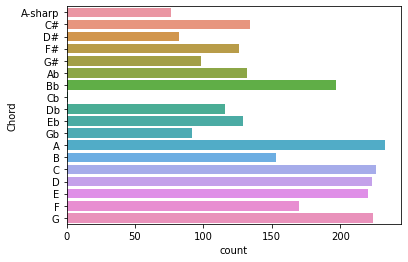

In [61]:
sns.countplot(y='Chord',data=chords)

## Handling Missing Data

Be back at 1 PM!

## Attribution

<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="images/PDSH-cover-small.png">

*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

The difference between data found in many tutorials and data in the real world is that real-world data is rarely clean and homogeneous.
In particular, many interesting datasets will have some amount of data missing.
To make matters even more complicated, different data sources may indicate missing data in different ways.

In this section, we will discuss some general considerations for missing data, discuss how Pandas chooses to represent it, and demonstrate some built-in Pandas tools for handling missing data in Python.
Here and throughout the book, we'll refer to missing data in general as *null*, *NaN*, or *NA* values.

## Trade-Offs in Missing Data Conventions

There are a number of schemes that have been developed to indicate the presence of missing data in a table or DataFrame.
Generally, they revolve around one of two strategies: using a *mask* that globally indicates missing values, or choosing a *sentinel value* that indicates a missing entry.

In the masking approach, the mask might be an entirely separate Boolean array, or it may involve appropriation of one bit in the data representation to locally indicate the null status of a value.

In the sentinel approach, the sentinel value could be some data-specific convention, such as indicating a missing integer value with -9999 or some rare bit pattern, or it could be a more global convention, such as indicating a missing floating-point value with NaN (Not a Number), a special value which is part of the IEEE floating-point specification.

None of these approaches is without trade-offs: use of a separate mask array requires allocation of an additional Boolean array, which adds overhead in both storage and computation. A sentinel value reduces the range of valid values that can be represented, and may require extra (often non-optimized) logic in CPU and GPU arithmetic. Common special values like NaN are not available for all data types.

As in most cases where no universally optimal choice exists, different languages and systems use different conventions.
For example, the R language uses reserved bit patterns within each data type as sentinel values indicating missing data, while the SciDB system uses an extra byte attached to every cell which indicates a NA state.

## Missing Data in Pandas

The way in which Pandas handles missing values is constrained by its reliance on the NumPy package, which does not have a built-in notion of NA values for non-floating-point data types.

Pandas could have followed R's lead in specifying bit patterns for each individual data type to indicate nullness, but this approach turns out to be rather unwieldy.
While R contains four basic data types, NumPy supports *far* more than this: for example, while R has a single integer type, NumPy supports *fourteen* basic integer types once you account for available precisions, signedness, and endianness of the encoding.
Reserving a specific bit pattern in all available NumPy types would lead to an unwieldy amount of overhead in special-casing various operations for various types, likely even requiring a new fork of the NumPy package. Further, for the smaller data types (such as 8-bit integers), sacrificing a bit to use as a mask will significantly reduce the range of values it can represent.

NumPy does have support for masked arrays – that is, arrays that have a separate Boolean mask array attached for marking data as "good" or "bad."
Pandas could have derived from this, but the overhead in both storage, computation, and code maintenance makes that an unattractive choice.

With these constraints in mind, Pandas chose to use sentinels for missing data, and further chose to use two already-existing Python null values: the special floating-point ``NaN`` value, and the Python ``None`` object.
This choice has some side effects, as we will see, but in practice ends up being a good compromise in most cases of interest.

### ``None``: Pythonic missing data

The first sentinel value used by Pandas is ``None``, a Python singleton object that is often used for missing data in Python code.
Because it is a Python object, ``None`` cannot be used in any arbitrary NumPy/Pandas array, but only in arrays with data type ``'object'`` (i.e., arrays of Python objects):

In [62]:
import numpy as np
import pandas as pd

In [66]:
vals1 = np.array([1, None, 3, 4])
vals1

array([1, None, 3, 4], dtype=object)

This ``dtype=object`` means that the best common type representation NumPy could infer for the contents of the array is that they are Python objects.
While this kind of object array is useful for some purposes, any operations on the data will be done at the Python level, with much more overhead than the typically fast operations seen for arrays with native types:

In [65]:
for dtype in ['object', 'int']:
    print("dtype =", dtype)
    %timeit np.arange(1E6, dtype=dtype).sum()
    print()

dtype = object
146 ms ± 5.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

dtype = int
2.16 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



The use of Python objects in an array also means that if you perform aggregations like ``sum()`` or ``min()`` across an array with a ``None`` value, you will generally get an error:

In [67]:
vals1

array([1, None, 3, 4], dtype=object)

In [73]:
1 + None

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [68]:
vals1.sum()

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

This reflects the fact that addition between an integer and ``None`` is undefined.

### ``NaN``: Missing numerical data

The other missing data representation, ``NaN`` (acronym for *Not a Number*), is different; it is a special floating-point value recognized by all systems that use the standard IEEE floating-point representation:

In [71]:
vals2 = np.array([1, np.nan, 3, 4]) 
vals2.dtype

dtype('float64')

Notice that NumPy chose a native floating-point type for this array: this means that unlike the object array from before, this array supports fast operations pushed into compiled code.
You should be aware that ``NaN`` is a bit like a data virus–it infects any other object it touches.
Regardless of the operation, the result of arithmetic with ``NaN`` will be another ``NaN``:

In [72]:
1 + np.nan

nan

In [7]:
0 *  np.nan

nan

Note that this means that aggregates over the values are well defined (i.e., they don't result in an error) but not always useful:

In [74]:
vals2.sum(), vals2.min(), vals2.max()

(nan, nan, nan)

NumPy does provide some special aggregations that will ignore these missing values:

In [9]:
np.nansum(vals2), np.nanmin(vals2), np.nanmax(vals2)

(8.0, 1.0, 4.0)

Keep in mind that ``NaN`` is specifically a floating-point value; there is no equivalent NaN value for integers, strings, or other types.

### NaN and None in Pandas

``NaN`` and ``None`` both have their place, and Pandas is built to handle the two of them nearly interchangeably, converting between them where appropriate:

In [10]:
pd.Series([1, np.nan, 2, None])

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

For types that don't have an available sentinel value, Pandas automatically type-casts when NA values are present.
For example, if we set a value in an integer array to ``np.nan``, it will automatically be upcast to a floating-point type to accommodate the NA:

In [11]:
x = pd.Series(range(2), dtype=int)
x

0    0
1    1
dtype: int64

In [12]:
x[0] = None
x

0    NaN
1    1.0
dtype: float64

Notice that in addition to casting the integer array to floating point, Pandas automatically converts the ``None`` to a ``NaN`` value.
(Be aware that there is a proposal to add a native integer NA to Pandas in the future; as of this writing, it has not been included).

While this type of magic may feel a bit hackish compared to the more unified approach to NA values in domain-specific languages like R, the Pandas sentinel/casting approach works quite well in practice and in my experience only rarely causes issues.

The following table lists the upcasting conventions in Pandas when NA values are introduced:

|Typeclass     | Conversion When Storing NAs | NA Sentinel Value      |
|--------------|-----------------------------|------------------------|
| ``floating`` | No change                   | ``np.nan``             |
| ``object``   | No change                   | ``None`` or ``np.nan`` |
| ``integer``  | Cast to ``float64``         | ``np.nan``             |
| ``boolean``  | Cast to ``object``          | ``None`` or ``np.nan`` |

Keep in mind that in Pandas, string data is always stored with an ``object`` dtype.

## Operating on Null Values

As we have seen, Pandas treats ``None`` and ``NaN`` as essentially interchangeable for indicating missing or null values.
To facilitate this convention, there are several useful methods for detecting, removing, and replacing null values in Pandas data structures.
They are:

- ``isnull()``: Generate a boolean mask indicating missing values
- ``notnull()``: Opposite of ``isnull()``
- ``dropna()``: Return a filtered version of the data
- ``fillna()``: Return a copy of the data with missing values filled or imputed

We will conclude this section with a brief exploration and demonstration of these routines.

### Detecting null values
Pandas data structures have two useful methods for detecting null data: ``isnull()`` and ``notnull()``.
Either one will return a Boolean mask over the data. For example:

In [77]:
data = pd.DataFrame([1, np.nan, 'hello', None])
data

,0
0,1
1,NaN
2,hello
3,None


In [82]:
data[data.notnull()]

,0
0,1
1,NaN
2,hello
3,NaN


In [79]:
data.isnull()

,0
0,False
1,True
2,False
3,True


As mentioned in [Data Indexing and Selection](03.02-Data-Indexing-and-Selection.ipynb), Boolean masks can be used directly as a ``Series`` or ``DataFrame`` index:

In [83]:
data[data.notnull()]

,0
0,1
1,NaN
2,hello
3,NaN


The ``isnull()`` and ``notnull()`` methods produce similar Boolean results for ``DataFrame``s.

### Dropping null values

In addition to the masking used before, there are the convenience methods, ``dropna()``
(which removes NA values) and ``fillna()`` (which fills in NA values). For a ``Series``,
the result is straightforward:

In [84]:
data

,0
0,1
1,NaN
2,hello
3,None


In [87]:
data.dropna().reset_index(drop=True)

,0
0,1
1,hello


For a ``DataFrame``, there are more options.
Consider the following ``DataFrame``:

In [88]:
df = pd.DataFrame([[1,      np.nan, 2],
                   [2,      3,      5],
                   [np.nan, 4,      6]])
df

,0,1,2
0,1.0,NaN,2
1,2.0,3.0,5
2,NaN,4.0,6


We cannot drop single values from a ``DataFrame``; we can only drop full rows or full columns.
Depending on the application, you might want one or the other, so ``dropna()`` gives a number of options for a ``DataFrame``.

By default, ``dropna()`` will drop all rows in which *any* null value is present:

In [89]:
df.dropna()

,0,1,2
1,2.0,3.0,5


Alternatively, you can drop NA values along a different axis; ``axis=1`` drops all columns containing a null value:

In [90]:
df.dropna(axis='columns')

,2
0,2
1,5
2,6


But this drops some good data as well; you might rather be interested in dropping rows or columns with *all* NA values, or a majority of NA values.
This can be specified through the ``how`` or ``thresh`` parameters, which allow fine control of the number of nulls to allow through.

The default is ``how='any'``, such that any row or column (depending on the ``axis`` keyword) containing a null value will be dropped.
You can also specify ``how='all'``, which will only drop rows/columns that are *all* null values:

In [91]:
df[3] = np.nan
df

,0,1,2,3
0,1.0,NaN,2,NaN
1,2.0,3.0,5,NaN
2,NaN,4.0,6,NaN


In [21]:
df.dropna(axis='columns', how='all')

,0,1,2
0,1.0,NaN,2
1,2.0,3.0,5
2,NaN,4.0,6


For finer-grained control, the ``thresh`` parameter lets you specify a minimum number of non-null values for the row/column to be kept:

In [92]:
df.dropna(axis='rows', thresh=3)

,0,1,2,3
1,2.0,3.0,5,NaN


Here the first and last row have been dropped, because they contain only two non-null values.

### Filling null values

Sometimes rather than dropping NA values, you'd rather replace them with a valid value.
This value might be a single number like zero, or it might be some sort of imputation or interpolation from the good values.
You could do this in-place using the ``isnull()`` method as a mask, but because it is such a common operation Pandas provides the ``fillna()`` method, which returns a copy of the array with the null values replaced.

Consider the following ``Series``:

In [93]:
data = pd.Series([1, np.nan, 2, None, 3], index=list('abcde'))
data

a    1.0
b    NaN
c    2.0
d    NaN
e    3.0
dtype: float64

In [95]:
np.mean(data)

2.0

We can fill NA entries with a single value, such as zero:

In [97]:
data.fillna(0)

a    1.0
b    0.0
c    2.0
d    0.0
e    3.0
dtype: float64

In [94]:
data.fillna(0).mean()

1.2

We can specify a forward-fill to propagate the previous value forward:

In [25]:
# forward-fill
data.fillna(method='ffill')

a    1.0
b    1.0
c    2.0
d    2.0
e    3.0
dtype: float64

Or we can specify a back-fill to propagate the next values backward:

In [26]:
# back-fill
data.fillna(method='bfill')

a    1.0
b    2.0
c    2.0
d    3.0
e    3.0
dtype: float64

For ``DataFrame``s, the options are similar, but we can also specify an ``axis`` along which the fills take place:

In [27]:
df

,0,1,2,3
0,1.0,NaN,2,NaN
1,2.0,3.0,5,NaN
2,NaN,4.0,6,NaN


In [98]:
df.fillna(method='ffill', axis='columns')

,0,1,2,3
0,1.0,1.0,2.0,2.0
1,2.0,3.0,5.0,5.0
2,NaN,4.0,6.0,6.0


Notice that if a previous value is not available during a forward fill, the NA value remains.

## Break

## Combining Datasets: Concat and Append

Some of the most interesting studies of data come from combining different data sources.
These operations can involve anything from very straightforward concatenation of two different datasets, to more complicated database-style joins and merges that correctly handle any overlaps between the datasets.
``Series`` and ``DataFrame``s are built with this type of operation in mind, and Pandas includes functions and methods that make this sort of data wrangling fast and straightforward.

Here we'll take a look at simple concatenation of ``Series`` and ``DataFrame``s with the ``pd.concat`` function; later we'll dive into more sophisticated in-memory merges and joins implemented in Pandas.

We begin with the standard imports:

In [1]:
import pandas as pd
import numpy as np

For convenience, we'll define this function which creates a ``DataFrame`` of a particular form that will be useful below:

In [99]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    data = {c: [str(c) + str(i) for i in ind]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
make_df('ABC', range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


In addition, we'll create a quick class that allows us to display multiple ``DataFrame``s side by side. The code makes use of the special ``_repr_html_`` method, which IPython uses to implement its rich object display:

In [100]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)
    

The use of this will become clearer as we continue our discussion in the following section.

## Recall: Concatenation of NumPy Arrays

Concatenation of ``Series`` and ``DataFrame`` objects is very similar to concatenation of Numpy arrays, which can be done via the ``np.concatenate`` function as discussed in [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb).
Recall that with it, you can combine the contents of two or more arrays into a single array:

In [4]:
x = [1, 2, 3]
y = [4, 5, 6]
z = [7, 8, 9]
np.concatenate([x, y, z])

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

The first argument is a list or tuple of arrays to concatenate.
Additionally, it takes an ``axis`` keyword that allows you to specify the axis along which the result will be concatenated:

In [5]:
x = [[1, 2],
     [3, 4]]
np.concatenate([x, x], axis=1)

array([[1, 2, 1, 2],
       [3, 4, 3, 4]])

## Simple Concatenation with ``pd.concat``

Pandas has a function, ``pd.concat()``, which has a similar syntax to ``np.concatenate`` but contains a number of options that we'll discuss momentarily:

```python
# Signature in Pandas v0.18
pd.concat(objs, axis=0, join='outer', join_axes=None, ignore_index=False,
          keys=None, levels=None, names=None, verify_integrity=False,
          copy=True)
```

``pd.concat()`` can be used for a simple concatenation of ``Series`` or ``DataFrame`` objects, just as ``np.concatenate()`` can be used for simple concatenations of arrays:

In [6]:
ser1 = pd.Series(['A', 'B', 'C'], index=[1, 2, 3])
ser2 = pd.Series(['D', 'E', 'F'], index=[4, 5, 6])
pd.concat([ser1, ser2])

1    A
2    B
3    C
4    D
5    E
6    F
dtype: object

It also works to concatenate higher-dimensional objects, such as ``DataFrame``s:

In [101]:
df1 = make_df('AB', [1, 2])
df2 = make_df('AB', [3, 4])
display('df1', 'df2', 'pd.concat([df1, df2])')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


By default, the concatenation takes place row-wise within the ``DataFrame`` (i.e., ``axis='rows'``).
Like ``np.concatenate``, ``pd.concat`` allows specification of an axis along which concatenation will take place.
Consider the following example:

In [8]:
df3 = make_df('AB', [0, 1])
df4 = make_df('CD', [0, 1])
display('df3', 'df4', "pd.concat([df3, df4], axis='col')")

df3
    A   B
0  A0  B0
1  A1  B1

df4
    C   D
0  C0  D0
1  C1  D1

pd.concat([df3, df4], axis='col')
    A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1

We could have equivalently specified ``axis=1``; here we've used the more intuitive ``axis='col'``. 

### Duplicate indices

One important difference between ``np.concatenate`` and ``pd.concat`` is that Pandas concatenation *preserves indices*, even if the result will have duplicate indices!
Consider this simple example:

In [104]:
x = make_df('AB', [0, 1])
y = make_df('AB', [2, 3])
y.index = x.index  # make duplicate indices!
display('x', 'y', 'pd.concat([x, y])')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


Notice the repeated indices in the result.
While this is valid within ``DataFrame``s, the outcome is often undesirable.
``pd.concat()`` gives us a few ways to handle it.

#### Catching the repeats as an error

If you'd like to simply verify that the indices in the result of ``pd.concat()`` do not overlap, you can specify the ``verify_integrity`` flag.
With this set to True, the concatenation will raise an exception if there are duplicate indices.
Here is an example, where for clarity we'll catch and print the error message:

In [108]:
pd.concat([x, y])

,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


In [109]:
try:
    pd.concat([x, y], verify_integrity=True)
except ValueError as e:
    print("ValueError:", e)

ValueError: Indexes have overlapping values: Int64Index([0, 1], dtype='int64')


#### Ignoring the index

Sometimes the index itself does not matter, and you would prefer it to simply be ignored.
This option can be specified using the ``ignore_index`` flag.
With this set to true, the concatenation will create a new integer index for the resulting ``Series``:

In [11]:
display('x', 'y', 'pd.concat([x, y], ignore_index=True)')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
2,A2,B2
3,A3,B3


#### Adding MultiIndex keys

Another option is to use the ``keys`` option to specify a label for the data sources; the result will be a hierarchically indexed series containing the data:

In [12]:
display('x', 'y', "pd.concat([x, y], keys=['x', 'y'])")

x
    A   B
0  A0  B0
1  A1  B1

y
    A   B
0  A2  B2
1  A3  B3

pd.concat([x, y], keys=['x', 'y'])
      A   B
x 0  A0  B0
  1  A1  B1
y 0  A2  B2
  1  A3  B3

The result is a multiply indexed ``DataFrame``, and we can use the tools discussed in [Hierarchical Indexing](03.05-Hierarchical-Indexing.ipynb) to transform this data into the representation we're interested in.

### Concatenation with joins

In the simple examples we just looked at, we were mainly concatenating ``DataFrame``s with shared column names.
In practice, data from different sources might have different sets of column names, and ``pd.concat`` offers several options in this case.
Consider the concatenation of the following two ``DataFrame``s, which have some (but not all!) columns in common:

In [13]:
df5 = make_df('ABC', [1, 2])
df6 = make_df('BCD', [3, 4])
display('df5', 'df6', 'pd.concat([df5, df6])')

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6])
     A   B   C    D
1   A1  B1  C1  NaN
2   A2  B2  C2  NaN
3  NaN  B3  C3   D3
4  NaN  B4  C4   D4

By default, the entries for which no data is available are filled with NA values.
To change this, we can specify one of several options for the ``join`` and ``join_axes`` parameters of the concatenate function.
By default, the join is a union of the input columns (``join='outer'``), but we can change this to an intersection of the columns using ``join='inner'``:

In [14]:
display('df5', 'df6',
        "pd.concat([df5, df6], join='inner')")

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6], join='inner')
    B   C
1  B1  C1
2  B2  C2
3  B3  C3
4  B4  C4

Another option is to directly specify the index of the remaininig colums using the ``join_axes`` argument, which takes a list of index objects.
Here we'll specify that the returned columns should be the same as those of the first input:

display('df5', 'df6',
        "pd.concat([df5, df6], join_axes=[df5.columns])")

The combination of options of the ``pd.concat`` function allows a wide range of possible behaviors when joining two datasets; keep these in mind as you use these tools for your own data.

### The ``append()`` method

Because direct array concatenation is so common, ``Series`` and ``DataFrame`` objects have an ``append`` method that can accomplish the same thing in fewer keystrokes.
For example, rather than calling ``pd.concat([df1, df2])``, you can simply call ``df1.append(df2)``:

In [16]:
display('df1', 'df2', 'df1.append(df2)')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


Keep in mind that unlike the ``append()`` and ``extend()`` methods of Python lists, the ``append()`` method in Pandas does not modify the original object–instead it creates a new object with the combined data.
It also is not a very efficient method, because it involves creation of a new index *and* data buffer.
Thus, if you plan to do multiple ``append`` operations, it is generally better to build a list of ``DataFrame``s and pass them all at once to the ``concat()`` function.

In the next section, we'll look at another more powerful approach to combining data from multiple sources, the database-style merges/joins implemented in ``pd.merge``.
For more information on ``concat()``, ``append()``, and related functionality, see the ["Merge, Join, and Concatenate" section](http://pandas.pydata.org/pandas-docs/stable/merging.html) of the Pandas documentation.